# EB_V_MAX

## Setup

In [1]:
# If necessary:
import os
os.remove('snorkel.db')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

## Parsing

In [3]:
from snorkel import SnorkelSession
session = SnorkelSession()

### Define Parser

In [4]:
import os
from snorkel.parser import CorpusParser, HTMLParser, OmniParser
from snorkel.utils import get_ORM_instance
from snorkel.queries import split_corpus

docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware100_html/'
doc_parser = HTMLParser(path=docs_path)
context_parser = OmniParser()
cp = CorpusParser(doc_parser, context_parser, max_docs=100) 

### Run Parser

In [ ]:
%time corpus = cp.parse_corpus(name='Hardware', session=session)

session.add(corpus)
session.commit()

[========                                ] 18%

### Split Corpus

In [ ]:
from snorkel.models import Corpus

corpus = get_ORM_instance(Corpus, session, 'Hardware')
split_corpus(session, corpus, train=0.8, development=0.2, test=0, seed=7)

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ corpus');

## Extraction

In [ ]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ corpus snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

In [ ]:
from snorkel.models import candidate_subclass

Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])

### Define Matchers

In [ ]:
from snorkel.matchers import RegexMatchSpan, Union

eeca_matcher = RegexMatchSpan(rgx='([b]{1}[abcdefklnpqruyz]{1}[\swxyz]?[0-9]{3,5}[\s]?[A-Z\/]{0,5}[0-9]?[A-Z]?([-][A-Z0-9]{1,7})?([-][A-Z0-9]{1,2})?)')
jedec_matcher = RegexMatchSpan(rgx='([123]N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)')
jis_matcher = RegexMatchSpan(rgx='(2S[abcdefghjkmqrstvz]{1}[\d]{2,4})')
others_matcher = RegexMatchSpan(rgx='((NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|TIS|TIPL|DTC|MMBT|PZT){1}[\d]{2,4}[A-Z]{0,3}([-][A-Z0-9]{0,6})?([-][A-Z0-9]{0,1})?)')
parts_matcher = Union(eeca_matcher, jedec_matcher, jis_matcher, others_matcher)

#NOTE: This is super specific.
eb_v_matcher = RegexMatchSpan(rgx=r'\-?([56]|12).0', longest_match_only=False)

### Define ContextSpaces

In [ ]:
import os
from collections import defaultdict
from hardware_utils import OmniNgramsPart, OmniNgramsTemp, get_gold_dict

# Make parts list
gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
gold_parts = get_gold_dict(gold_file, doc_on=True, part_on=True, val_on=False)
parts_by_doc = defaultdict(set)
for part in gold_parts:
    parts_by_doc[part[0]].add(part[1])
    
part_ngrams = OmniNgramsPart(parts_by_doc=parts_by_doc, n_max=3)

# TODO: This is missing the current represented as an Amp rather than a milliamp
eb_v_ngrams = OmniNgramsTemp(n_max=3)

In [ ]:
from snorkel.lf_helpers import *

def EBVThrottler((part_span, attr_span)):
    """
    Removes candidates unless the part is not in a table, or the part aligned
    temperature are not aligned.
    """
    def aligned(span1, span2):
        return (span1.parent.table == span2.parent.table and
            (span1.parent.row_num == span2.parent.row_num or
             span1.parent.col_num == span2.parent.col_num))
    
    if (part_span.parent.table is None):
        ngrams = set(get_row_ngrams(attr_span))
        if ('vebo' in ngrams or
            'v ebo' in ngrams or
            'emitter-base' in ngrams):
            return True
    
    if (aligned(part_span, attr_span)):
        ngrams = set(get_row_ngrams(attr_span))
        if ('vebo' in ngrams or
            'v ebo' in ngrams or
            'emitter-base' in ngrams):
            return True
    
    return False

### Run CandidateExtractor

In [ ]:
from snorkel.models import Corpus
from snorkel.candidates import CandidateExtractor
from snorkel.utils import get_ORM_instance


ce = CandidateExtractor(Part_Voltage, 
                        [part_ngrams, eb_v_ngrams], 
                        [parts_matcher, eb_v_matcher],
                        throttler=EBVThrottler)

for corpus_name in ['Hardware Training', 'Hardware Development']:
    corpus = get_ORM_instance(Corpus, session, corpus_name)
    print "Extracting Candidates from %s" % corpus
    %time candidates = ce.extract(\
        corpus.documents, corpus_name + ' Candidates', session)
    session.add(candidates)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

### Assess Recall

In [ ]:
from snorkel.models import CandidateSet
from hardware_utils import entity_level_total_recall, most_common_document, get_gold_dict
from snorkel.models import Candidate

all_candidates = session.query(Candidate).all()
gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'

# gold_dict = get_gold_dict(gold_file, attrib='c_current_max')

(tp, fp, fn) = entity_level_total_recall(
    all_candidates, gold_file, 'eb_v_max', relation=True)
print len(tp)
print len(fp)
print len(fn)

In [ ]:
from pprint import pprint
fns = list(fn)
pprint(sorted(fns))

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ candidates');

## Gold Labels

In [ ]:
# If necessary
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ candidates snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])

In [ ]:
import os
from snorkel.models import CandidateSet
from hardware_utils import load_hardware_labels

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
for set_name in ['Training', 'Development']:
    candidate_set_name = 'Hardware %s Candidates' % set_name
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    label_set_name = 'Hardware %s Candidates -- Gold' % set_name
    annotation_key_name = 'Hardware %s Labels -- Gold' % set_name
    %time gold_candidates, annotation_key = load_hardware_labels(session,\
                           label_set_name, \
                           annotation_key_name, \
                           candidates, \
                           gold_file, \
                           attrib='eb_v_max')
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates in %s have positive Labels" % (
        len(candidates_gold), len(candidates), candidates)

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ labels');

## Features

In [ ]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ labels snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])

### Extract Features

In [ ]:
from snorkel.models import CandidateSet
from snorkel.fast_annotations import FeatureManager
from snorkel.utils import get_ORM_instance

train = get_ORM_instance(CandidateSet, session, 'Hardware Training Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Development Candidates')

feature_manager = FeatureManager()
%time F_train = feature_manager.create(session, train, 'Train Features')
%time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

In [ ]:
# If necessary:
import os
os.system('cp snorkel.db snorkel.db\ featurized');

## LFs

In [ ]:
# If necessary
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ featurized snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])
from snorkel.models import CandidateSet
train = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates').one()

### Define LFs

In [ ]:
from snorkel.fast_annotations import LabelManager
from snorkel.lf_helpers import *
label_manager = LabelManager()

# Helpers
def set_all_in_set(a, b):
    '''return true if all of a is in b'''
    return b.issuperset(a)

def set_none_in_set(a, b):
    '''return true if none of a is in b'''
    return (b.difference(a) == b)

def set_any_in_set(a, b):
    '''return true if any of a is in b'''
    return len(b.intersection(a)) > 0

LFs = []

###################################################################
# POSITIVE
###################################################################

def LF_voltage_inside_table(c):
    return 1 if c.voltage.parent.row is not None else 0
LFs.append(LF_voltage_inside_table)

# def LF_part_is_aligned(c):
#     return 1 if (c.part.parent.table == c.voltage.parent.table and
#                 (c.part.parent.row_num == c.voltage.parent.row_num or
#                  c.part.parent.col_num == c.voltage.parent.col_num)) else 0
# LFs.append(LF_part_is_aligned)
    
def LF_ce_keywords(c):
    individuals = set(['collector', 'emitter', 'voltage'])
    together = set(['collector-emitter', 'voltage'])
    row_ngrams = set(x.replace(' ', '') for x in get_row_ngrams(c.voltage, infer=True))
    if set_all_in_set(individuals, row_ngrams):
        return 1
    if set_all_in_set(together, row_ngrams):
        return 1
    return 0
LFs.append(LF_ce_keywords)

def LF_pos_keywords_in_row(c):
    pos_keys = set(['v ceo', 'ceo', 'vceo', 'value', 'rating'])
    ngrams = set(get_row_ngrams(c.voltage, infer=True))
    if set_any_in_set(pos_keys, ngrams):
        return 1
    else:
        return 0
LFs.append(LF_pos_keywords_in_row)

def LF_low_table_num(c):
    if c.voltage.parent.table <= 2:
        return 1
    else:
        return -1
LFs.append(LF_low_table_num)

def LF_whole_phrase_in_row(c):
    row_ngrams = set(get_row_ngrams(c.voltage))
    if 'collector-emitter voltage' in row_ngrams:
        return 1
    else:
        return 0
LFs.append(LF_whole_phrase_in_row)


###################################################################
# NEGATIVE
###################################################################

def LF_specific_neg_row_keywords(c):
    left_ngrams = set(get_row_ngrams(c.voltage, infer=True))
    neg_keys = set(['continuous', 'dc', 'cut-off'])
    if set_any_in_set(neg_keys, left_ngrams):
        return -1
    else:
        return 0
LFs.append(LF_specific_neg_row_keywords)

def LF_equals_in_row(c):
    row_ngrams = set(get_row_ngrams(c.voltage))
    if '=' in row_ngrams:
        return -1
    else:
        return 0
LFs.append(LF_equals_in_row)

def LF_i_in_row(c):
    row_ngrams = set(get_row_ngrams(c.voltage))
    if 'i' in row_ngrams:
        return -1
    else:
        return 0
LFs.append(LF_i_in_row)

def LF_first_row(c):
    if c.voltage.parent.row_num == 0:
        return -1
    else:
        return 0
LFs.append(LF_first_row)
    
def LF_not_ce_relevant(c):
    ce_keywords = set(['collector', 'emitter', 'collector-emitter'])
    ngrams = set(get_aligned_ngrams(c.voltage))
    if not set_any_in_set(ce_keywords, ngrams):
        return -1
    else:
        return 1
LFs.append(LF_not_ce_relevant)

def LF_too_many_numbers_row(c):
    num_numbers = list(get_row_ngrams(c.voltage, attrib="ner_tags")).count('number')
    return -1 if num_numbers >= 4 else 0
LFs.append(LF_too_many_numbers_row)

def LF_negative_keywords(c):
    row_neg_keys = set(['ambient',
                    'small-signal',
                    'cut-off',
                    'na',
                    'ma',
                    'cex',
                    'resistance',
                    'power',
                    'junction',
                    'dissipation', 
                    'breakdown',
                    'current',
                    'cbo',
                    'vcbo'
                    'peak',
                    '=',
                    'f',
                    'p',
                    'base',
                    'mw',
                    'ebo',
                    'vebo',
                    'i c',
                    'total',
                    'device',
                    'c',
                    'mhz',
                    'temperature',
                    'saturation',
                    'operating',
                    'storage'
                    'bandwidth',
                    'derate',
                    'above',
                    'product',
                    'figure',
                    'conditions',
                    'current gain',
                    'saturation',
                    'min',
                    'min.',
                    'typ',
                    'typ.',
                    'max',
                    'max.',
                    'gain',
                    'p',
                    'thermal',
                    'test'])
    row_ngrams = set(get_row_ngrams(c.voltage))
    col_ngrams = set(get_col_ngrams(c.voltage))
    col_neg_keys = set(['conditions', 
                        'condition', 
                        'parameter', 
                        'min',
                        'min.',
                        'typ',
                        'typ.',
                        'max',
                        'max.',
                        'test'])
    if set_any_in_set(row_neg_keys, row_ngrams):
        return -1
    if set_any_in_set(col_neg_keys, col_ngrams):
        return -1
    
    return 0

LFs.append(LF_negative_keywords)
    
# def LF_negative_keywords_in_col(c):
#     neg_keys = set(['conditions',
#                     'condition',
#                     'parameter',
#                     'test'])
#     ngrams = set(get_col_ngrams(c.voltage))
#     if set_any_in_set(neg_keys, ngrams):
#         return -1
#     else:
#         return 0

# LFs.append(LF_negative_keywords_in_col)

# def LF_negative_keywords_in_part_aligned(c):
#     ngrams = set(get_aligned_ngrams(c.part))
#     return -1 if (
#         'gain'          in ngrams or
#         'small-signal'  in ngrams or
#         'small'         in ngrams or
#         'cbo'         in ngrams or
#         'collector-emitter' in ngrams or
#         'value'         in ngrams or
#         'thermal'       in ngrams) else 0
# LFs.append(LF_negative_keywords_in_part_aligned)

# def LF_negative_keywords(c):
#     ngrams = set(get_aligned_ngrams(c.voltage))
#     return -1 if (
#         'collector-base'    in ngrams or
#         'cut-off'           in ngrams or
#         '='                 in ngrams or
#         'gain'              in ngrams or
#         'h fe'              in ngrams or
#         'typ.'              in ngrams or
#         'typ'               in ngrams or
#         'min'               in ngrams or
#         'min.'              in ngrams or
#         'saturation'        in ngrams or
#         'mhz'               in ngrams or
#         'gain'              in ngrams or
#         'obo'               in ngrams or
#         'c obo'             in ngrams) else 0
# LFs.append(LF_negative_keywords)


### Apply LFs

In [ ]:
%time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

### Assess LF accuracy

In [ ]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()
%time L_train.lf_stats(train_gold)

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ features');

## Learn and Evaluate

In [1]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ features snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])
from snorkel.models import CandidateSet
train = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates').one()
dev = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates').one()

In [2]:
from snorkel.fast_annotations import FeatureManager, LabelManager
feature_manager = FeatureManager()
%time F_train = feature_manager.load(session, train, 'Train Features')
%time F_dev = feature_manager.load(session, dev, 'Train Features')

label_manager = LabelManager()
%time L_train = label_manager.load(session, train, 'LF Labels')

CPU times: user 6min 24s, sys: 12.4 s, total: 6min 37s
Wall time: 6min 35s
CPU times: user 4min 16s, sys: 8.6 s, total: 4min 24s
Wall time: 4min 23s
CPU times: user 22.1 s, sys: 568 ms, total: 22.6 s
Wall time: 22.5 s


In [3]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=15000, rate=1e-2)
%time gen_model.save(session, 'Generative Params')
train_marginals = gen_model.marginals(L_train)

/home/lwhsiao/repos/snorkel/.virtualenv/local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Training marginals (!= 0.5):	299827
Features:			10
Begin training for rate=0.01, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.225489
	Learning epoch = 250	Gradient mag. = 0.276617
	Learning epoch = 500	Gradient mag. = 0.354472
	Learning epoch = 750	Gradient mag. = 0.478081
	Learning epoch = 1000	Gradient mag. = 0.631336
	Learning epoch = 1250	Gradient mag. = 0.781048
	Learning epoch = 1500	Gradient mag. = 0.691724
	Learning epoch = 1750	Gradient mag. = 0.613290
	Learning epoch = 2000	Gradient mag. = 0.577689
	Learning epoch = 2250	Gradient mag. = 0.566642
	Learning epoch = 2500	Gradient mag. = 0.392611
	Learning epoch = 2750	Gradient mag. = 0.299027
	Learning epoch = 3000	Gradient mag. = 0.260019
	Learning epoch = 3250	Gradient mag. = 0.256259
	Learning epoch = 3500	Gradient mag. = 0.275768
	Learning epoch = 3750	Gradient mag. = 0.309399
	Learning epoch = 4000	Gradient mag. = 0.348174
	Learning epoch = 4250	Gradient mag. = 0.387286
	Learning epoch = 4500	Gradient mag. = 0.423138
	Lea

In [4]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=4000, rate=1e-4)
%time disc_model.save(session, "Discriminative Params")

Training marginals (!= 0.5):	299827
Features:			31537
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 207824.239706	Gradient magnitude = 511142.884199
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 453246.485839	Gradient magnitude = 133535.933704
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 238260.790074	Gradient magnitude = 76775.908310
	Learning epoch = 300	Step size = 7.40707032156e-05
	Loss = 508387.270872	Gradient magnitude = 85677.833812
	Learning epoch = 400	Step size = 6.70185906007e-05
	Loss = 383453.973987	Gradient magnitude = 85677.625292
	Learning epoch = 500	Step size = 6.06378944861e-05
	Loss = 272859.295242	Gradient magnitude = 138418.161957
	Learning epoch = 600	Step size = 5.48646907485e-05
	Loss = 366941.208475	Gradient magnitude = 85215.163735
	Learning epoch = 700	Step size = 4.96411413431e-05
	Loss = 198746.559188	Gradient magnitude = 80562.053126
	Learning epoch = 800	Step size = 4.4914914861e-05
	Loss = 438074.

Calibration plot:


/home/lwhsiao/repos/snorkel/.virtualenv/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


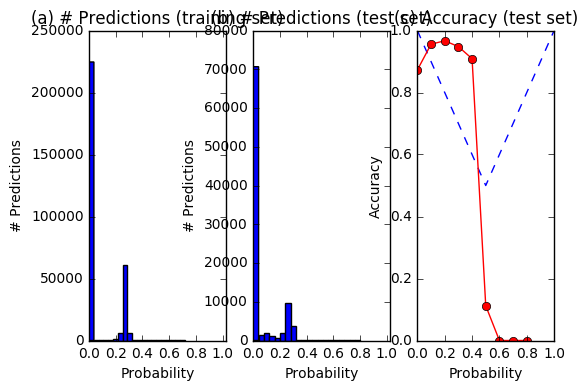

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.00129922046772
Neg. class accuracy: 0.997987534913
Corpus Precision 0.073
Corpus Recall    0.0013
Corpus F1        0.00255
----------------------------------------
TP: 13 | FP: 165 | TN: 81824 | FN: 9993

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.00129922046772
Neg. class accuracy: 0.997987534913
Corpus Precision 0.073
Corpus Recall    0.0013
Corpus F1        0.00255
----------------------------------------
TP: 13 | FP: 165 | TN: 81824 | FN: 9993



In [5]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()

dev_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates -- Gold').one()

from snorkel.models import CandidateSet
from snorkel.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Development Labels -- Gold')

tp, fp, tn, fn = disc_model.score(F_dev, L_dev, dev_gold)

In [6]:
from snorkel.models import Corpus
from hardware_utils import entity_level_f1
import os

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Development').one()
(TP, FP, FN) = entity_level_f1(tp, fp, tn, fn, gold_file, corpus, 'eb_v_max')


Scoring on Entity-Level Gold Data
Corpus Precision 0.116
Corpus Recall    0.0442
Corpus F1        0.064
----------------------------------------
TP: 8 | FP: 61 | FN: 173



In [10]:
from pprint import pprint
FN_list = sorted(list(FN))
FP_list = sorted(list(FP))
TP_list = sorted(list(TP))
pprint(FN_list[:60])

[('2N3906', '2N3906', '-40'),
 ('2N3906', '2N3906BU', '-40'),
 ('2N3906', '2N3906TA', '-40'),
 ('2N3906', '2N3906TAR', '-40'),
 ('2N3906', '2N3906TF', '-40'),
 ('2N3906', '2N3906TFR', '-40'),
 ('2N3906', 'MMBT3906', '-40'),
 ('2N3906', 'PZT3906', '-40'),
 ('2N4124', '2N4124', '25'),
 ('2N4124', 'MMBT4124', '25'),
 ('BC182-D', 'BC182', '50'),
 ('BC182-D', 'BC182B', '50'),
 ('BC182-D', 'BC182BG', '50'),
 ('BC182-D', 'BC182BRL1G', '50'),
 ('BC182-D', 'BC182G', '50'),
 ('BC546-D', 'BC546', '65'),
 ('BC546-D', 'BC546B', '65'),
 ('BC546-D', 'BC546BG', '65'),
 ('BC546-D', 'BC546BRL1', '65'),
 ('BC546-D', 'BC546BRL1G', '65'),
 ('BC546-D', 'BC546BZL1G', '65'),
 ('BC546-D', 'BC547', '45'),
 ('BC546-D', 'BC547A', '45'),
 ('BC546-D', 'BC547ARL', '45'),
 ('BC546-D', 'BC547ARLG', '45'),
 ('BC546-D', 'BC547AZL1G', '45'),
 ('BC546-D', 'BC547B', '45'),
 ('BC546-D', 'BC547BG', '45'),
 ('BC546-D', 'BC547BRL1G', '45'),
 ('BC546-D', 'BC547BZL1G', '45'),
 ('BC546-D', 'BC547C', '45'),
 ('BC546-D', 'BC547CG',

In [17]:
from hardware_utils import entity_to_candidates

entity = FN_list[61]
print entity
print

matches = entity_to_candidates(entity, fn)
print "# Matches: %d" % len(matches)
candidate = matches[0]
print candidate

print "\nPhrase:"
print candidate.voltage.parent

print disc_model.get_candidate_score(candidate, F_dev)
print
pprint(disc_model.get_candidate_feature_weights(candidate, F_dev))

('BC547', 'BC547CTFR', '45')

# Matches: 20
Part_Voltage(ImplicitSpan("BC547CTFR", parent=3770, words=[1,3], position=[10]), ImplicitSpan("45", parent=86564, words=[0,0], position=[0]))

Phrase:
Phrase(Doc: BC547, Table: 1, Row: 5, Col: 1, Position: 0, Text: 45)
-46.3874929747

[(AnnotationKey (TAB_e2_HTML_ANC_TAG_[table]), -5.926182626946603),
 (AnnotationKey (TAB_e2_HTML_ANC_TAG_[tr]), -5.926182626946603),
 (AnnotationKey (TAB_e2_HTML_ANC_TAG_[td]), -5.926182626946603),
 (AnnotationKey (TAB_e2_COL_WORDS_[30]), -1.9780498172698082),
 (AnnotationKey (TAB_e2_COL_WORDS_[50]), -1.8764822619656558),
 (AnnotationKey (TAB_e2_COL_WORDS_[)]), -1.4365031547663245),
 (AnnotationKey (TAB_e2_COL_WORDS_[current]), -1.4228573693017605),
 (AnnotationKey (TAB_e2_COL_WORDS_[voltage]), -1.4017220592396662),
 (AnnotationKey (TAB_e2_COL_WORDS_[5]), -1.348140821310086),
 (AnnotationKey (TAB_e2_COL_WORDS_[collector]), -1.3223436729884115),
 (AnnotationKey (TAB_e2_COL_WORDS_[(]), -1.2312706025450515),
 (Anno

In [ ]:

import os
os.system('cp snorkel.db snorkel.db\ final');